In [2]:
# The path can also be read from a config file, etc.
OPENSLIDE_PATH = r'C:\openslide-bin-4.0.0.6-windows-x64\bin'

import os
if hasattr(os, 'add_dll_directory'):
    # Windows
    with os.add_dll_directory(OPENSLIDE_PATH):
        import openslide
else:
    import openslide


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import cv2


In [4]:
# Function to extract patches from the WSI
def extract_patches(wsi, patch_size, step_size):
    patches = []
    h, w = wsi.dimensions  # Get the dimensions of the full WSI
    for x in range(0, w - patch_size, step_size):
        for y in range(0, h - patch_size, step_size):
            patch = np.array(wsi.read_region((x, y), 0, (patch_size, patch_size)))[:, :, :3]
            patches.append(patch)
    return patches


In [5]:
# Function to extract features (you can modify this to use other feature extraction methods)
def extract_color_histograms(patch):
    # Convert patch to HSV color space
    hsv_patch = cv2.cvtColor(patch, cv2.COLOR_RGB2HSV)
    
    # Compute histogram for each channel and concatenate them
    hist_h = cv2.calcHist([hsv_patch], [0], None, [256], [0, 256])
    hist_s = cv2.calcHist([hsv_patch], [1], None, [256], [0, 256])
    hist_v = cv2.calcHist([hsv_patch], [2], None, [256], [0, 256])
    
    # Normalize histograms
    hist_h = hist_h / np.sum(hist_h)
    hist_s = hist_s / np.sum(hist_s)
    hist_v = hist_v / np.sum(hist_v)
    
    # Flatten and concatenate histograms
    hist = np.concatenate((hist_h, hist_s, hist_v)).flatten()
    
    return hist


In [8]:
# Load the WSI file using OpenSlide
wsi_path = r"C:\Users\lakho\Downloads\TCGA-3L-AA1B-01Z-00-DX2.17CE3683-F4B1-4978-A281-8F620C4D77B4.svs"

wsi = openslide.OpenSlide(wsi_path)

In [9]:
# Parameters for patch extraction
patch_size = 256  # Size of each patch (you can adjust this)
step_size = 256   # Step size to move across the WSI


In [10]:
# Extract patches from the WSI
patches = extract_patches(wsi, patch_size, step_size)


In [11]:
# Extract features (e.g., color histograms) from each patch
features = [extract_color_histograms(patch) for patch in patches]

# Convert features list to numpy array for KMeans
features = np.array(features)

In [12]:
# Apply K-Means clustering to the patches
kmeans = KMeans(n_clusters=3, random_state=42)  # You can change n_clusters as needed
labels = kmeans.fit_predict(features)


In [13]:
# Visualize the clusters
# Create a blank canvas to visualize the clustering results on the WSI
canvas = np.zeros((int(wsi.dimensions[1] / patch_size) * patch_size, int(wsi.dimensions[0] / patch_size) * patch_size, 3), dtype=np.uint8)

# Assign colors to each cluster
cluster_colors = [
    [255, 0, 0],  # Red for cluster 0
    [0, 255, 0],  # Green for cluster 1
    [0, 0, 255],  # Blue for cluster 2
]

In [14]:
# Place each patch on the canvas according to its cluster label
i = 0
for x in range(0, wsi.dimensions[0] - patch_size, step_size):
    for y in range(0, wsi.dimensions[1] - patch_size, step_size):
        color = cluster_colors[labels[i]]
        canvas[y:y+patch_size, x:x+patch_size] = color
        i += 1


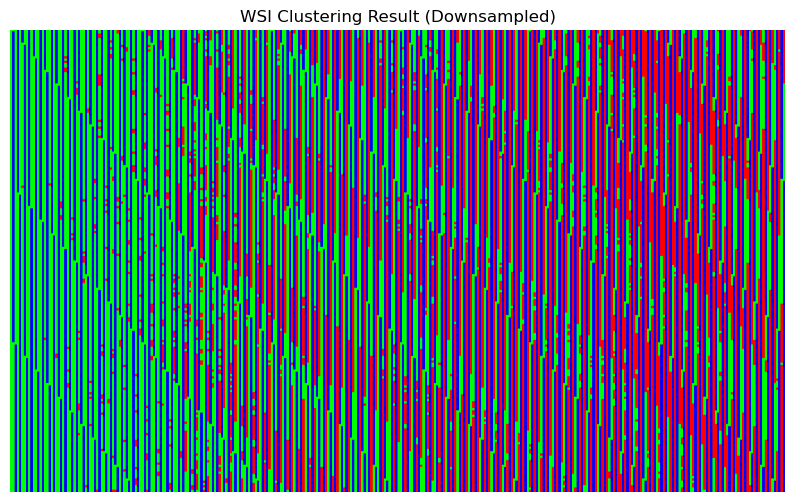

In [16]:
# Downsample the image by a factor (e.g., 4x smaller)
downsample_factor = 4
small_canvas = canvas[::downsample_factor, ::downsample_factor]

# Display the downsampled image
plt.figure(figsize=(10, 10))
plt.imshow(small_canvas)
plt.title("WSI Clustering Result (Downsampled)")
plt.axis("off")
plt.show()


In [17]:
wsi.close()